In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys  
from pathlib import Path

ROOT = Path.cwd().parent
sys.path.insert(0, str(ROOT))

#Archivos propios
import src.models as models
import src.preprocessing as pre
import src.metrics as metrics


In [2]:

# Cargar datasets
imb_dev = pd.read_csv(ROOT / "Ejercicio 1" / "data" / "raw" / "cell_diagnosis_imbalanced_dev.csv")
imb_test = pd.read_csv(ROOT / "Ejercicio 1" / "data" / "raw" / "cell_diagnosis_imbalanced_test.csv")
bal_dev = pd.read_csv(ROOT / "Ejercicio 1" / "data" / "raw" / "cell_diagnosis_balanced_dev.csv")
bal_test = pd.read_csv(ROOT / "Ejercicio 1" / "data" / "raw" / "cell_diagnosis_balanced_test.csv")

# Ver las primeras filas y shape de cada uno
print("Imbalanced Dev:", imb_dev.shape)
print("Imbalanced Test:", imb_test.shape)
print("Balanced Dev:", bal_dev.shape)
print("Balanced Test:", bal_test.shape)

print("\nEjemplo (balanced dev):")
print(bal_dev.head())

Imbalanced Dev: (1218, 15)
Imbalanced Test: (136, 15)
Balanced Dev: (1663, 15)
Balanced Test: (185, 15)

Ejemplo (balanced dev):
    CellSize  CellShape  NucleusDensity  ChromatinTexture  CytoplasmSize  \
0  63.423148   0.500594        1.473261         23.300222            NaN   
1  72.906362   0.474808        1.361360         21.336137      29.856233   
2  70.711969   0.481701             NaN         21.521406      30.582427   
3  73.210206        NaN        1.427612         22.437077      29.887970   
4  68.348288        NaN        1.454116         21.150723      28.328197   

   CellAdhesion  MitosisRate  NuclearMembrane  GrowthFactor  OxygenSaturation  \
0      0.477657     3.434832         2.492852    -10.000000         78.625935   
1      0.481035     2.702433         2.281137     63.084699               NaN   
2      0.472651     2.786606         2.318029     61.347022               NaN   
3      0.439511     2.998380         2.149232     64.047169         80.693058   
4        

In [3]:
print(bal_dev.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1663 entries, 0 to 1662
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CellSize             1333 non-null   float64
 1   CellShape            1347 non-null   float64
 2   NucleusDensity       1362 non-null   float64
 3   ChromatinTexture     1366 non-null   float64
 4   CytoplasmSize        1347 non-null   float64
 5   CellAdhesion         1369 non-null   float64
 6   MitosisRate          1343 non-null   float64
 7   NuclearMembrane      1343 non-null   float64
 8   GrowthFactor         1359 non-null   float64
 9   OxygenSaturation     1375 non-null   float64
 10  Vascularization      1347 non-null   float64
 11  InflammationMarkers  1358 non-null   float64
 12  Diagnosis            1663 non-null   float64
 13  CellType             1407 non-null   object 
 14  GeneticMutation      1663 non-null   object 
dtypes: float64(13), object(2)
memory usage

In [4]:
# Divido el set de dev en train y test
train_df, test_df = pre.split_train_val(bal_dev)

# Eliminar filas con datos faltantes en la columna "Diagnosis" de todos los datasets
train_df = train_df.dropna(subset=["Diagnosis"])
test_df = test_df.dropna(subset=["Diagnosis"])

# Completo los NaNs de las columnas categóricas con la moda de cada columna
train_df = pre.add_missing_values_mode(train_df, ["CellType", "GeneticMutation"])
test_df = pre.add_missing_values_mode(test_df, ["CellType", "GeneticMutation"])

# One-Hot Encoding de las variables categóricas "CellType" y "GeneticMutation"
train_df = pd.get_dummies(train_df, columns=["CellType", "GeneticMutation"], drop_first=True)
test_df = pd.get_dummies(test_df, columns=["CellType", "GeneticMutation"], drop_first=True)

# Normalizo usando mu y sigma del set de test para evitar data leakage
train_df, test_df, mu , sigma = pre.normalize(train_df, test_df, target_name="Diagnosis")

# Completo los NaNs de las columnas numéricas usando KNN
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.drop("Diagnosis")

train_df = pre.handle_missing_values(train_df, numeric_cols, method='knn')
test_df = pre.handle_missing_values(test_df, numeric_cols, method='knn')

print(train_df.info())




<class 'pandas.core.frame.DataFrame'>
Index: 1330 entries, 1448 to 1386
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CellSize                1330 non-null   float64
 1   CellShape               1330 non-null   float64
 2   NucleusDensity          1330 non-null   float64
 3   ChromatinTexture        1330 non-null   float64
 4   CytoplasmSize           1330 non-null   float64
 5   CellAdhesion            1330 non-null   float64
 6   MitosisRate             1330 non-null   float64
 7   NuclearMembrane         1330 non-null   float64
 8   GrowthFactor            1330 non-null   float64
 9   OxygenSaturation        1330 non-null   float64
 10  Vascularization         1330 non-null   float64
 11  InflammationMarkers     1330 non-null   float64
 12  Diagnosis               1330 non-null   float64
 13  CellType_Epthlial       1330 non-null   bool   
 14  CellType_Mesnchymal     1330 non-null   bo

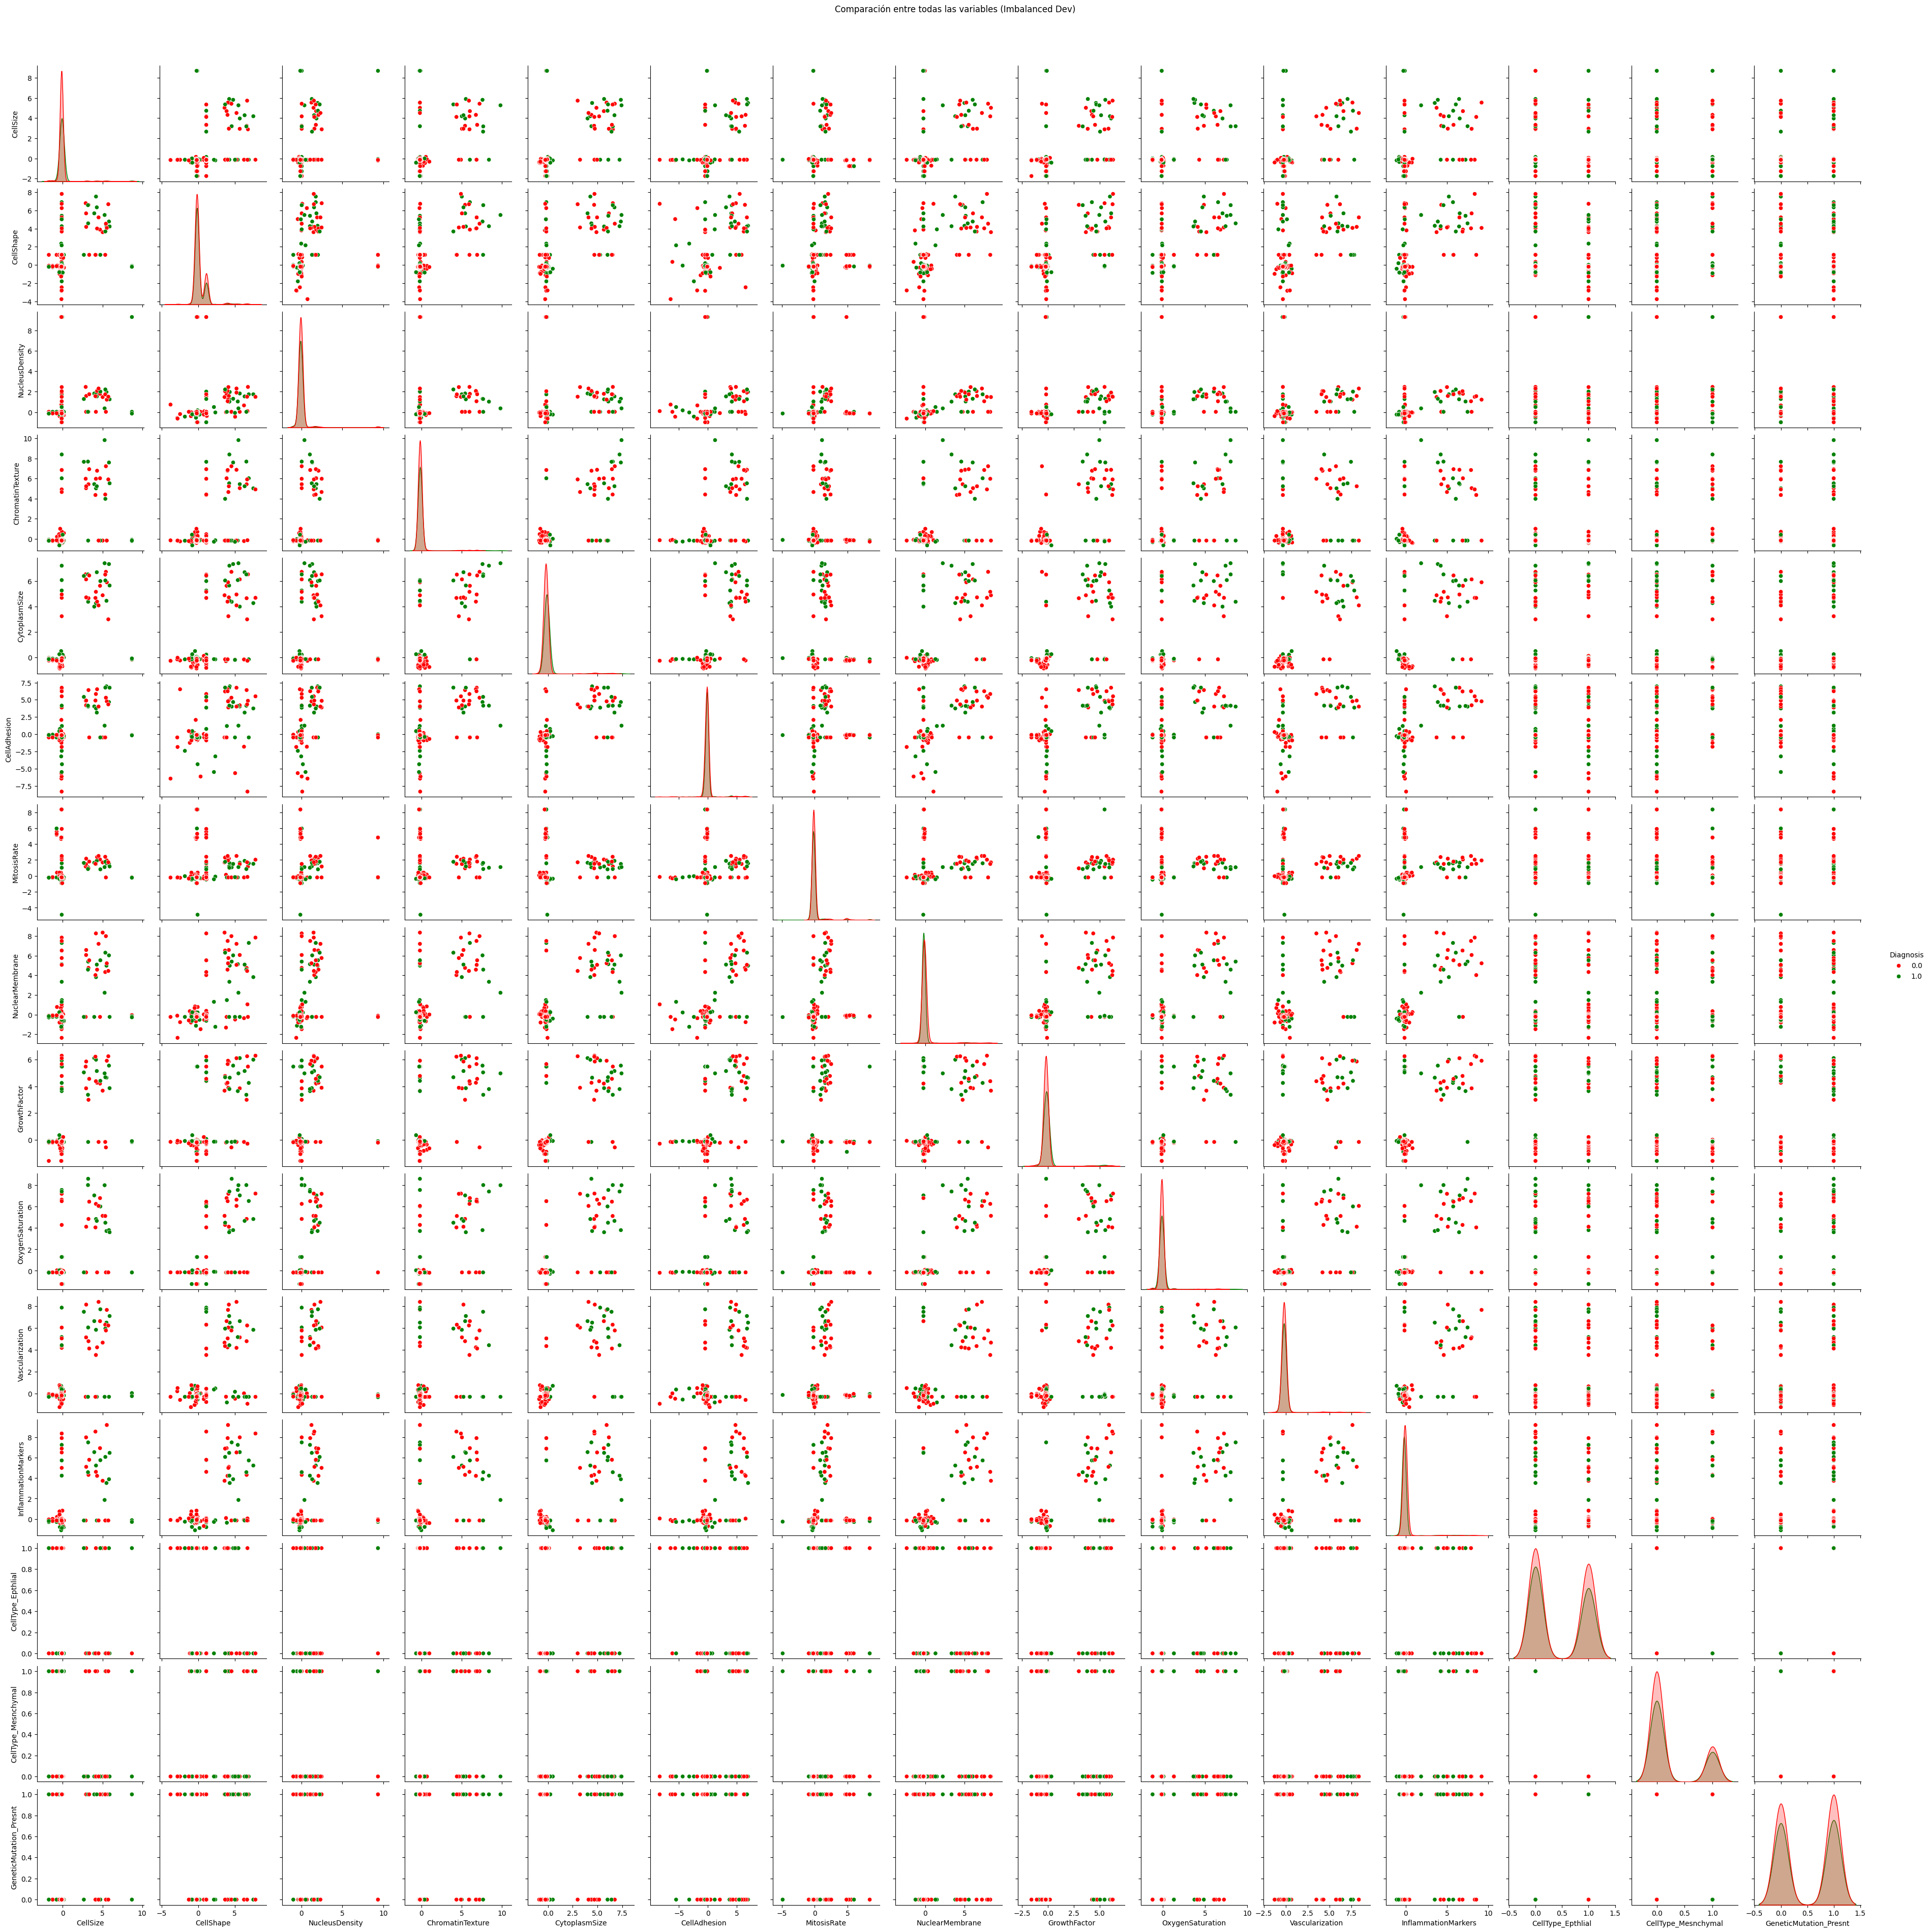

In [5]:
# Hacer scatter plots de las columnas para comparar todas con todas, coloreando por Diagnosis
palette = {0: "red", 1: "green"}
sns.pairplot(train_df, hue="Diagnosis", palette=palette)
plt.suptitle('Comparación entre todas las variables (Imbalanced Dev)', y=1.02)
plt.show()

lambda = 0.0001 weights norm = 2.5471721843717066
lambda = 0.00010476157527896651 weights norm = 2.54660960836428
lambda = 0.00010974987654930556 weights norm = 2.546020449607853
lambda = 0.00011497569953977356 weights norm = 2.5454034622151607
lambda = 0.00012045035402587823 weights norm = 2.5447573428993575
lambda = 0.0001261856883066021 weights norm = 2.54408072842602
lambda = 0.00013219411484660288 weights norm = 2.5433721929615714
lambda = 0.00013848863713938732 weights norm = 2.542630245316648
lambda = 0.000145082877849594 weights norm = 2.5418533260769998
lambda = 0.0001519911082952933 weights norm = 2.5410398046232787
lambda = 0.00015922827933410923 weights norm = 2.5401879760332102
lambda = 0.0001668100537200059 weights norm = 2.5392960578649775
lambda = 0.0001747528400007683 weights norm = 2.5383621868174986
lambda = 0.0001830738280295368 weights norm = 2.5373844152655454
lambda = 0.00019179102616724886 weights norm = 2.5363607076663017
lambda = 0.00020092330025650479 weights

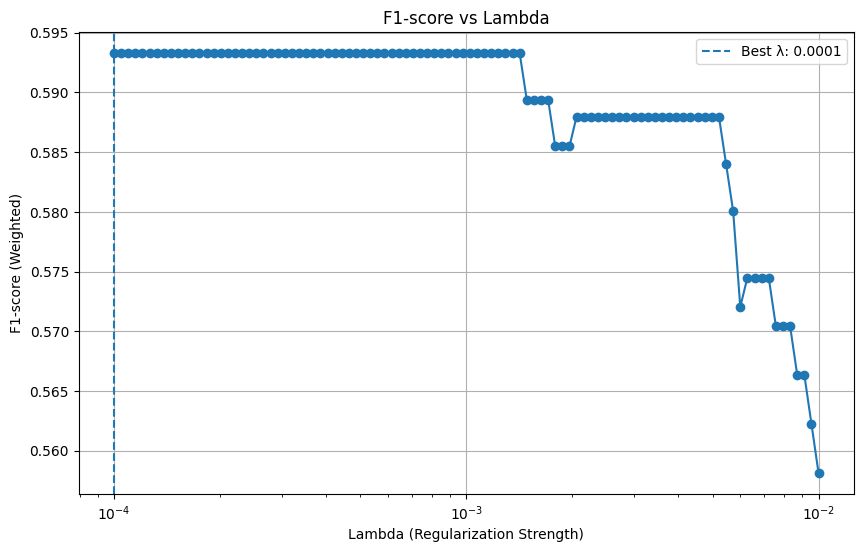

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Helpers ----------
def _ensure_float_matrix(X):
    # coerciona a float64 sin romper si viene de pandas
    return np.asarray(X, dtype=np.float64)

def _ensure_labels_array(y):
    # deja y como array (no fuerza a 0/1 porque puede ser multiclase)
    return np.asarray(y)

def _weighted_f1_from_dict(f1_dict, y_true, labels):
    # weighted por soporte real de y_true
    return float(sum(f1_dict[label] * np.sum(y_true == label) for label in labels) / len(y_true))

# ---------- Datos ----------
X_train = _ensure_float_matrix(train_df.drop(columns=["Diagnosis"]).values)
y_train = _ensure_labels_array(train_df["Diagnosis"].values)
X_val   = _ensure_float_matrix(test_df.drop(columns=["Diagnosis"]).values)
y_val   = _ensure_labels_array(test_df["Diagnosis"].values)

labels = np.unique(y_train)
n_classes = len(labels)

# ---------- Barrido de lambdas ----------
lambdas = np.logspace(-4, -2, 100)
best_lambda = None
best_f1 = -1.0
best_model = None         # binario: instancia; multiclase: dict {label: modelo}
f1_scores = []

# Tip: bajar un poco el lr para evitar overflows con lambdas grandes
LEARNING_RATE = 0.1
N_ITER = 1000

for L2 in lambdas:
    if n_classes == 2:
        # --- Caso binario ---
        model = models.LogisticRegressionL2(L2=L2, learning_rate=LEARNING_RATE, n_iter=N_ITER)
        model.fit(X_train, (y_train == labels[1]).astype(float))  # map a {0,1} respecto a la clase positiva
        y_val_pred = model.predict(X_val)                         # 0/1
        # Volvemos a etiquetas originales para métricas
        y_val_pred_labels = np.where(y_val_pred == 1, labels[1], labels[0])
        f1_dict = metrics.f1_score(y_val, y_val_pred_labels, labels)
        f1_w = _weighted_f1_from_dict(f1_dict, y_val, labels)
        f1_scores.append(f1_w)
        if f1_w > best_f1:
            best_f1 = f1_w
            best_lambda = L2
            best_model = model
        # logging opcional
        print("lambda =", L2, "weights norm =", np.linalg.norm(model.weights))

    else:
        # --- Caso multiclase (OvR/A&A): entrenamos un modelo por clase ---
        models_ovr = {}
        # Probabilidades por clase para el set de validación
        proba_val = np.zeros((len(X_val), n_classes), dtype=np.float64)

        for j, cls in enumerate(labels):
            y_train_bin = (y_train == cls).astype(float)
            m = models.LogisticRegressionL2(L2=L2, learning_rate=LEARNING_RATE, n_iter=N_ITER)
            m.fit(X_train, y_train_bin)
            models_ovr[cls] = m
            proba_val[:, j] = m.predict_proba(X_val)  # prob de "ser esa clase" vs resto

        # predicción = argmax de probabilidades OvR
        idx_max = np.argmax(proba_val, axis=1)
        y_val_pred_labels = labels[idx_max]

        f1_dict = metrics.f1_score(y_val, y_val_pred_labels, labels)
        f1_w = _weighted_f1_from_dict(f1_dict, y_val, labels)
        f1_scores.append(f1_w)
        if f1_w > best_f1:
            best_f1 = f1_w
            best_lambda = L2
            best_model = models_ovr
        # logging opcional: norma promedio
        mean_norm = np.mean([np.linalg.norm(m.weights) for m in models_ovr.values()])
        print("lambda =", L2, "mean weights norm =", mean_norm)

print(f"Best lambda: {best_lambda}, Best F1-score (weighted): {best_f1:.6f}")

# ---------- Gráfico F1-score vs lambda ----------
plt.figure(figsize=(10, 6))
plt.semilogx(lambdas, f1_scores, marker='o')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('F1-score (Weighted)')
plt.title('F1-score vs Lambda')
plt.grid(True)
plt.axvline(best_lambda, linestyle='--', label=f'Best λ: {best_lambda:.4g}')
plt.legend()
plt.show()


Reportar las siguientes métricas:
– Matriz de confusión
– Accuracy
– Precision
– Recall
– F1-Score
– Curva Precision-Recall (PR)
– Curva ROC
– AUC-ROC
– AUC-PR

=== Métricas binarias (validación) ===
Etiquetas: [0.0, 1.0]

Matriz de confusión (rows=true, cols=pred):
 [[167  16]
 [129  21]]

Accuracy: 0.564565
Precision por clase: {0.0: 0.564189, 1.0: 0.567568}
Recall por clase:    {0.0: 0.912568, 1.0: 0.14}
F1 por clase:        {0.0: 0.697286, 1.0: 0.224599}
F1 (macro): 0.460942 | F1 (weighted): 0.484364

AUC-PR (pos='1.0'):  0.571120
AUC-ROC (pos='1.0'): 0.613898


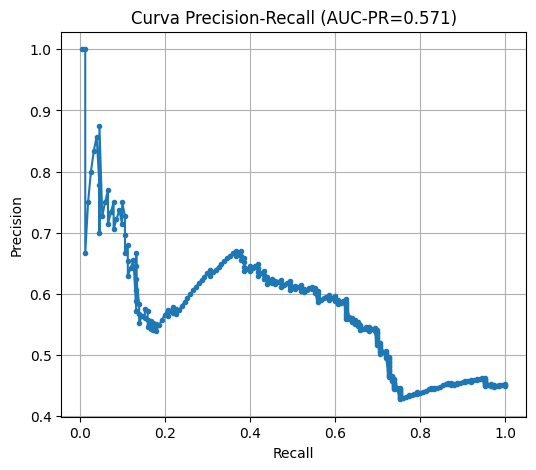

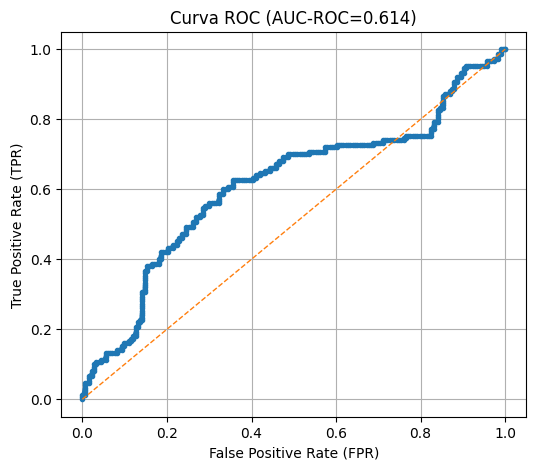